In [42]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2

# Dataset
### 15747 images (64,64,3)



In [43]:
dataset_dir = "./cats"

dataset = []
for each in os.listdir(dataset_dir):
    image = cv2.imread(os.path.join(dataset_dir, each))
    if type(image) != type(None):
        dataset.append(image)

dataset = np.array(dataset)
print(dataset.shape)

(15747, 64, 64, 3)


# Generator 


In [68]:
def generator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(4*4*1024, input_shape=(100,)))
    model.add(layers.Reshape((4, 4, 1024)))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(filters=512, kernel_size=(5,5), strides=(2,2), padding='same',
            kernel_initializer=tf.initializers.truncated_normal(stddev=0.02)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(filters=256, kernel_size=(5,5), strides=(2,2), padding='same',
             kernel_initializer=tf.initializers.truncated_normal(stddev=0.02)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(filters=128, kernel_size=(5,5), strides=(2,2), padding='same',
             kernel_initializer=tf.initializers.truncated_normal(stddev=0.02)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    

    model.add(layers.Conv2DTranspose(filters=64, kernel_size=(5,5), strides=(2,2), padding='same',
             kernel_initializer=tf.initializers.truncated_normal(stddev=0.02)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(filters=3, kernel_size=(5,5), strides=(1,1), padding='same',
             kernel_initializer=tf.initializers.truncated_normal(stddev=0.02),
             activation='tanh'))
    

    return model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[[[ 3.1735361e-04  5.0888379e-04  7.6645694e-05]
   [ 7.8586518e-04 -2.9769458e-04  4.5719693e-04]
   [ 1.5457185e-03  1.0553178e-03  2.3162957e-04]
   ...
   [ 3.5845430e-03 -4.0467063e-04  8.2978245e-04]
   [ 2.1161129e-04 -3.2772429e-04 -3.4363256e-05]
   [ 1.9311532e-05  8.0693170e-04  6.2545732e-04]]

  [[ 2.2775707e-04 -4.6441657e-04 -3.8027318e-04]
   [ 1.2601212e-03  4.1521233e-04 -6.0580095e-04]
   [-1.5872241e-03 -1.6787485e-04  1.3623765e-04]
   ...
   [ 5.7544955e-04  1.4314991e-03  1.8560942e-03]
   [-1.3388415e-03  2.0450172e-03  1.6209986e-03]
   [-1.1331451e-03 -8.5501396e-04  4.7821767e-04]]

  [[ 9.3051553e-04  2.7785922e-04  9.2295965e-04]
   [ 9.1236964e-04 -8.3217677e-04  5.0906243e-04]
   [ 1.7949253e-03  1.0317636e-03  8.3555444e-04]
   ...
   [ 1.4779766e-04 -1.9395945e-03  3.3904605e-03]
   [ 9.8524673e-04 -1.9400133e-03  2.0987953e-03]
   [ 1.6650766e-04 -1.3195679e-03  4.4618003e-04]]

  ...

  [[-9.3254907e-04 -3.5432610e-04  1.0742912e-03]
   [ 

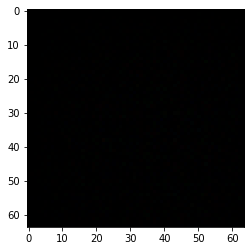

In [75]:
generator = generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image)
plt.imshow(generated_image[0, :, :, :])

# Discriminator

In [ ]:
def discriminator_model()